In [1]:
## Two analyses were performed in this script
## 1. enrichment of pathway genes across organizer markers
## 2. intersect organizer markers with pathway genes and visualize on a heatmap

library(Seurat)
library(ComplexHeatmap)
library(dplyr)
library(circlize)
library(ggplot2)
source("./pat.fun.R")


inputdir <- "./load_files/"
outputdir <- "./report/"

pat <- readRDS(file = paste0("../overview/load_files/", "PAT_inte.organizer.inte.rds"))
sel_cls <- c("PC FGF17", "PC NKX2-1 NKX6-2", "PC NKX2-1 LMO1", "GE_RG_NKX2-1_DLK1", "GE_RG_NKX2-1_OLIG1", 
             "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2")
pat@meta.data$cluster <- factor(as.character(pat@meta.data$subtype), levels = sel_cls)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Loading required package: grid

ComplexHeatmap version 2.2.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


circlize version 0.4.13
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and

In [2]:
##-----------------------------------------------------------------
## Obtain markers
source("./pat.fun.R")

load(file = paste0("../overview/load_files/", "PAT_markers.Rdata"))
cc_genes <- get_genes(input_genes = rownames(pat), gene_type = "cc", revised = TRUE)

slim_res <- read.table("./report/PAT_markers_table.txt",
                      header = TRUE, check.names = FALSE, stringsAsFactors = FALSE, sep = "\t")

## Pathway genes
new.list <- readRDS(file = "./load_files/Pathway_updated_20221219.rds")

In [3]:
head(slim_res)
table(slim_res$cluster)

,gene,p_val,avg_logFC,pct.1,pct.2,p_val_adj,ratio_fc,cluster,Pathway_BMP,Pathway_EPH,Pathway_FGF,Pathway_NOTCH,Pathway_WNT,Pathway_RA,Pathway_SHH
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,FGF17,5.250664e-256,3.0843909,0.791,0.018,2.210530e-253,28.607143,PC FGF17,0,0,1,0,0,0,0
2,FGF18,2.290939e-58,0.8820602,0.258,0.011,1.071650e-56,12.761905,PC FGF17,0,0,1,0,0,0,0
3,FGF3,1.284948e-27,0.6075258,0.115,0.003,1.690509e-26,9.615385,PC FGF17,0,0,1,0,0,0,0
4,SP8,1.294735e-83,0.9034394,0.373,0.033,1.090167e-81,8.906977,PC FGF17,0,0,0,0,0,0,0
5,LYN,3.139621e-23,0.2759942,0.105,0.004,3.004046e-22,8.214286,PC FGF17,0,1,0,0,0,1,0
6,FGF8,5.335056e-33,0.9133850,0.181,0.014,8.318735e-32,7.958333,PC FGF17,0,0,1,0,0,0,0



    AV NKX2-1 LMO1   AV NKX2-1 NKX6-2  GE RG NKX2-1 DLK1 GE RG NKX2-1 OLIG1 
               280                379                269                215 
          PC FGF17           PC RSPO3           PC SFRP2          PC TCF7L2 
               387                499                285                821 
            PC TTR 
              1102 

In [4]:
## how many genes annotated as markers
sapply(names(new.list), function(pa) length(unique(slim_res$gene[slim_res[, paste0("Pathway_", pa)] != 0])))

BMP   EPH   FGF NOTCH   WNT    RA   SHH 
   29    51    47    57   128    37    27

In [5]:
## how many genes annotated for each cell type
new_cls <- c("PC FGF17", "AV NKX2-1 NKX6-2", "AV NKX2-1 LMO1", 
             "GE RG NKX2-1 DLK1", "GE RG NKX2-1 OLIG1", 
             "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2")
lapply(new_cls, function(cls){
    subres <- filter(slim_res, cluster %in% cls)
    aa <- sapply(names(new.list), function(pa) sum(subres[, paste0("Pathway_", pa)]))
    return(aa)
}) %>% 
    setNames(., sel_cls) %>%
    as.data.frame()

,PC.FGF17,PC.NKX2.1.NKX6.2,PC.NKX2.1.LMO1,GE_RG_NKX2.1_DLK1,GE_RG_NKX2.1_OLIG1,PC.RSPO3,PC.TTR,PC.SFRP2,PC.TCF7L2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
BMP,6,6,2,1,3,6,15,2,2
EPH,7,9,5,6,2,5,17,3,13
FGF,8,9,8,3,1,9,11,3,9
NOTCH,8,10,18,8,12,18,12,5,4
WNT,12,21,21,14,11,31,31,10,28
RA,4,5,8,6,7,6,17,2,4
SHH,6,8,2,2,1,4,7,3,5


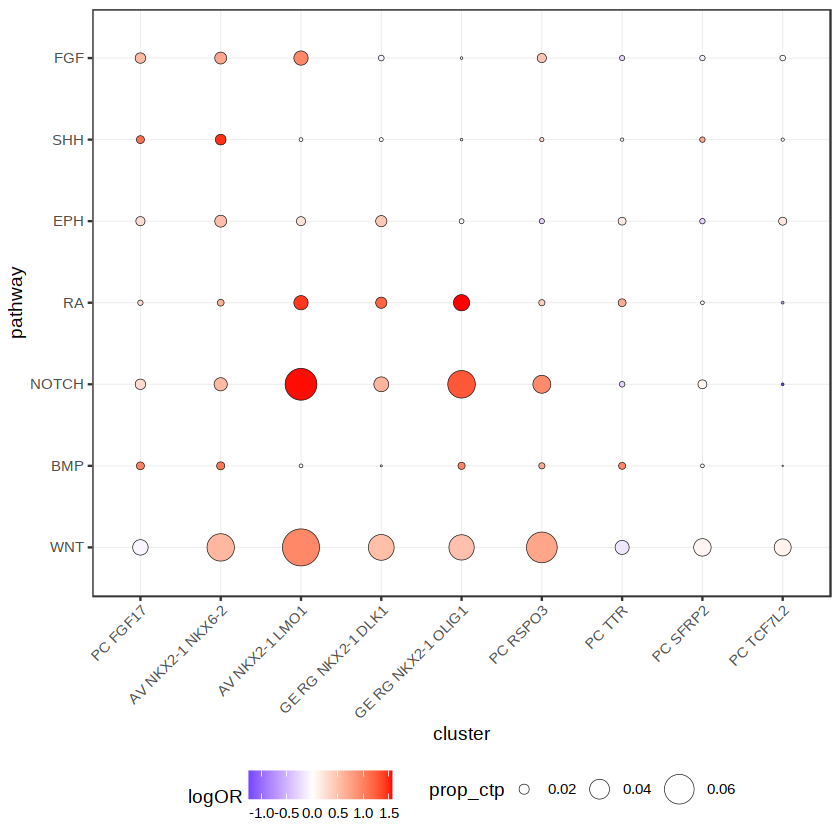

In [6]:
##-----------------------------------------------------------------
## Pathway proportions
CalcOddsRatio <- function(gsetlist, degs, expgenes, threshold = 3) {
    ## generate the 2by2 table
    orz <- sapply(names(gsetlist), function(dis) {
        dis_genes <- gsetlist[[dis]] %>%
                        intersect(., expgenes)
        bg_genes <- setdiff(expgenes, dis_genes)

        dis_yes <- length(intersect(dis_genes, degs))
        dis_no <- length(dis_genes) - dis_yes
        bg_yes <- length(intersect(bg_genes, degs))
        bg_no <- length(bg_genes) - bg_yes

        mat <- matrix(c(dis_yes, dis_no, bg_yes, bg_no), byrow = TRUE, nrow = 2, 
                      dimnames = list(c("Dis", "BG"), c("yes", "no")))

        or <- questionr::odds.ratio(mat, level = 0.95)$OR

        if (dis_yes < threshold) {
            or <- ifelse(dis_yes == 0, 0, 1)
        }

        return(or)
        })

    return(orz)
}


new_cls <- c("PC FGF17", "AV NKX2-1 NKX6-2", "AV NKX2-1 LMO1", 
             "GE RG NKX2-1 DLK1", "GE RG NKX2-1 OLIG1", 
             "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2")
exp_genes <- lapply(sel_cls, function(cls) {
                subpat <- pat[, pat@meta.data$cluster %in%cls]
                genes <- rownames(subpat)[Matrix::rowMeans(subpat$RNA@data != 0) >= 0.05]
                return(genes)
                }) %>%
                setNames(., new_cls)
new.list.update <- lapply(new.list, function(x) intersect(x, unique(unlist(exp_genes))))
size_ctp <- sapply(new_cls, function(cls) sum(slim_res$cluster %in% cls))
size_pa <- sapply(new.list, length)
size_df <- lapply(new_cls, function(cls) {
    genes <- filter(slim_res, cluster %in% cls) %>%
                .$gene
    pa_size <- sapply(new.list.update, function(pa) length(intersect(pa, genes)))
    logors <- CalcOddsRatio(gsetlist = new.list.update, degs = genes, expgenes = exp_genes[[cls]], threshold = 3) %>%
            log()
    df <- data.frame(pathway = names(pa_size),
                    size = pa_size,
                    logOR = logors,
                    prop_ctp = pa_size/size_ctp[[cls]],
                    prop_pathway = pa_size/size_pa[names(pa_size)],
                    cluster = cls,
                    stringsAsFactors = FALSE)
    return(df)
    }) %>%
    do.call(rbind, .) %>%
    mutate(cluster = factor(cluster, levels = new_cls)) %>%
    mutate(pathway = factor(pathway, levels = rev(c("FGF", "SHH", "EPH", "RA", "NOTCH", "BMP", "WNT"))))


p_prop <- ggplot(size_df, aes(x = cluster, y = pathway, size = prop_ctp, fill = logOR)) +
            geom_point(shape = 21, stroke = 0.2) +
            scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
            scale_radius(range = c(0, 10))+
            theme_bw() +
            ##coord_fixed() + 
            RotatedAxis() + 
            theme(legend.position = "bottom", 
                panel.grid.major = element_line(size = 0.2), panel.grid.minor = element_line(size = 0.2))
p_prop

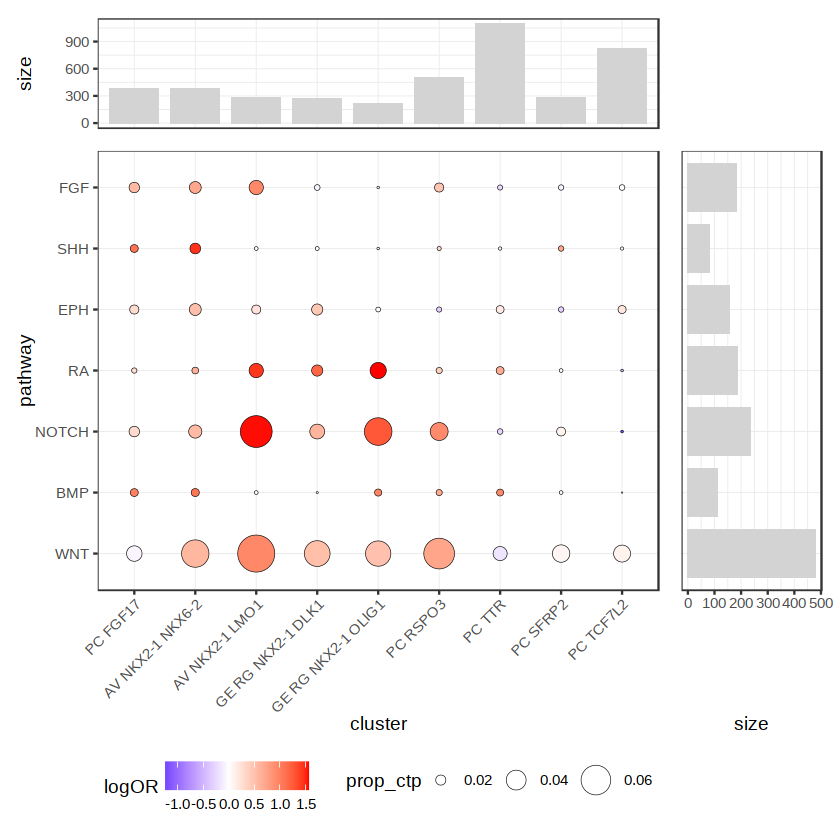

In [7]:
## Add pathway size and marker set size 
y_plot_data <- data.frame(size_pa) %>%
            setNames(., "size") %>%
            tibble::rownames_to_column("pathway") %>%
            as.data.frame() %>%
            mutate(pathway = factor(pathway, levels = rev(c("FGF", "SHH", "EPH", "RA", "NOTCH", "BMP", "WNT"))))
y_plot <- ggplot(y_plot_data, aes(x = size, y = pathway)) +
            geom_bar(stat = "identity", size = 0.2, width = 0.8, fill = "lightgrey") +
            theme_bw() +
            ##coord_fixed() + 
            theme(legend.position = "none", 
                panel.grid.major = element_line(size = 0.2), panel.grid.minor = element_line(size = 0.2),
                axis.title.y = element_blank(), axis.text.y = element_blank(), axis.ticks.y = element_blank())
x_plot_data <- data.frame(size_ctp) %>%
            setNames(., "size") %>%
            tibble::rownames_to_column("cluster") %>%
            as.data.frame() %>%
            mutate(cluster = factor(cluster, levels = names(size_ctp)))
x_plot <- ggplot(x_plot_data, aes(x = cluster, y = size)) +
            geom_bar(stat = "identity", size = 0.2, width = 0.8, fill = "lightgrey") +
            theme_bw() +
            ##coord_fixed() + 
            theme(legend.position = "none", 
                panel.grid.major = element_line(size = 0.2), panel.grid.minor = element_line(size = 0.2),
                axis.title.x = element_blank(), axis.text.x = element_blank(), axis.ticks.x = element_blank())
design <- "A#
           CD"
p_prop <- patchwork::wrap_plots(A = x_plot, C = p_prop, D = y_plot, 
                            design = design, nrow = 2, ncol = 2, widths = c(1, 0.25), heights = c(0.25, 1))
p_prop

In [8]:
pdf(paste0(outputdir, "PAT_markers_propEnrich_pathway.pdf"), width = 6.5, height = 6.5, useDingbats = FALSE)
print(p_prop)
dev.off()

png 
  2

In [9]:
##-----------------------------------------------------------------
## Plot pathway genes among the top 100 markers
## (if we don't do the top markers, there will be 420 genes, impossible to visualize)
rawmars <- split(slim_res$gene, slim_res$cluster) %>%
                .[new_cls]
mars <- lapply(new_cls, function(cls) {
    xx <- filter(slim_res, cluster %in% cls) %>%
            .$gene
    gg <- intersect(xx[1:min(length(xx), 100)], unique(unlist(new.list)))
    return(gg)
    }) %>%
    setNames(., new_cls)

In [10]:
## Prepare data for Heatmap visualization
plot.genes <- unlist(mars) %>% unique()
set.seed(42)
pat_plot <- lapply(sel_cls, function(x) {
        cells <- colnames(pat)[pat@meta.data$subtype == x]
        if (length(cells) > 200){
            cells <- sample(cells, 200)
        }
        cells
        }) %>% 
                unlist() %>%
                pat[, .]

mat <- pat_plot[["RNA"]]@data[plot.genes, ] %>% 
                as.matrix() %>%
                t() %>% scale() %>% t() %>%
                MinMax(., min = -1.5, max = 2)

In [11]:
## Annotation for cell type markers
annot_mar <- lapply(rawmars, function(x) {
                yy <- setNames(ifelse(plot.genes %in% x, 1, 0), plot.genes)
                return(yy)
                }) %>%
                as.data.frame(., check.names = FALSE) %>%
                as.matrix()
annot_pathway <- lapply(new.list, function(x) {
                yy <- setNames(ifelse(plot.genes %in% x, 1, 0), plot.genes)
                return(yy)
                }) %>%
                as.data.frame(., check.names = FALSE) %>%
                as.matrix() %>%
                .[, c("FGF", "SHH", "EPH", "RA", "NOTCH", "BMP", "WNT")]
head(annot_mar)
head(annot_pathway)

,PC FGF17,AV NKX2-1 NKX6-2,AV NKX2-1 LMO1,GE RG NKX2-1 DLK1,GE RG NKX2-1 OLIG1,PC RSPO3,PC TTR,PC SFRP2,PC TCF7L2
FGF17,1,0,0,0,0,0,0,0,0
FGF18,1,0,0,0,0,0,0,0,0
FGF3,1,0,0,0,0,0,0,0,0
LYN,1,0,0,0,0,0,0,0,0
FGF8,1,0,0,0,0,0,0,0,0
IL17RD,1,0,0,0,0,0,0,0,0


,FGF,SHH,EPH,RA,NOTCH,BMP,WNT
FGF17,1,0,0,0,0,0,0
FGF18,1,0,0,0,0,0,0
FGF3,1,0,0,0,0,0,0
LYN,0,0,1,1,0,0,0
FGF8,1,0,0,0,0,0,0
IL17RD,1,0,0,0,0,0,0


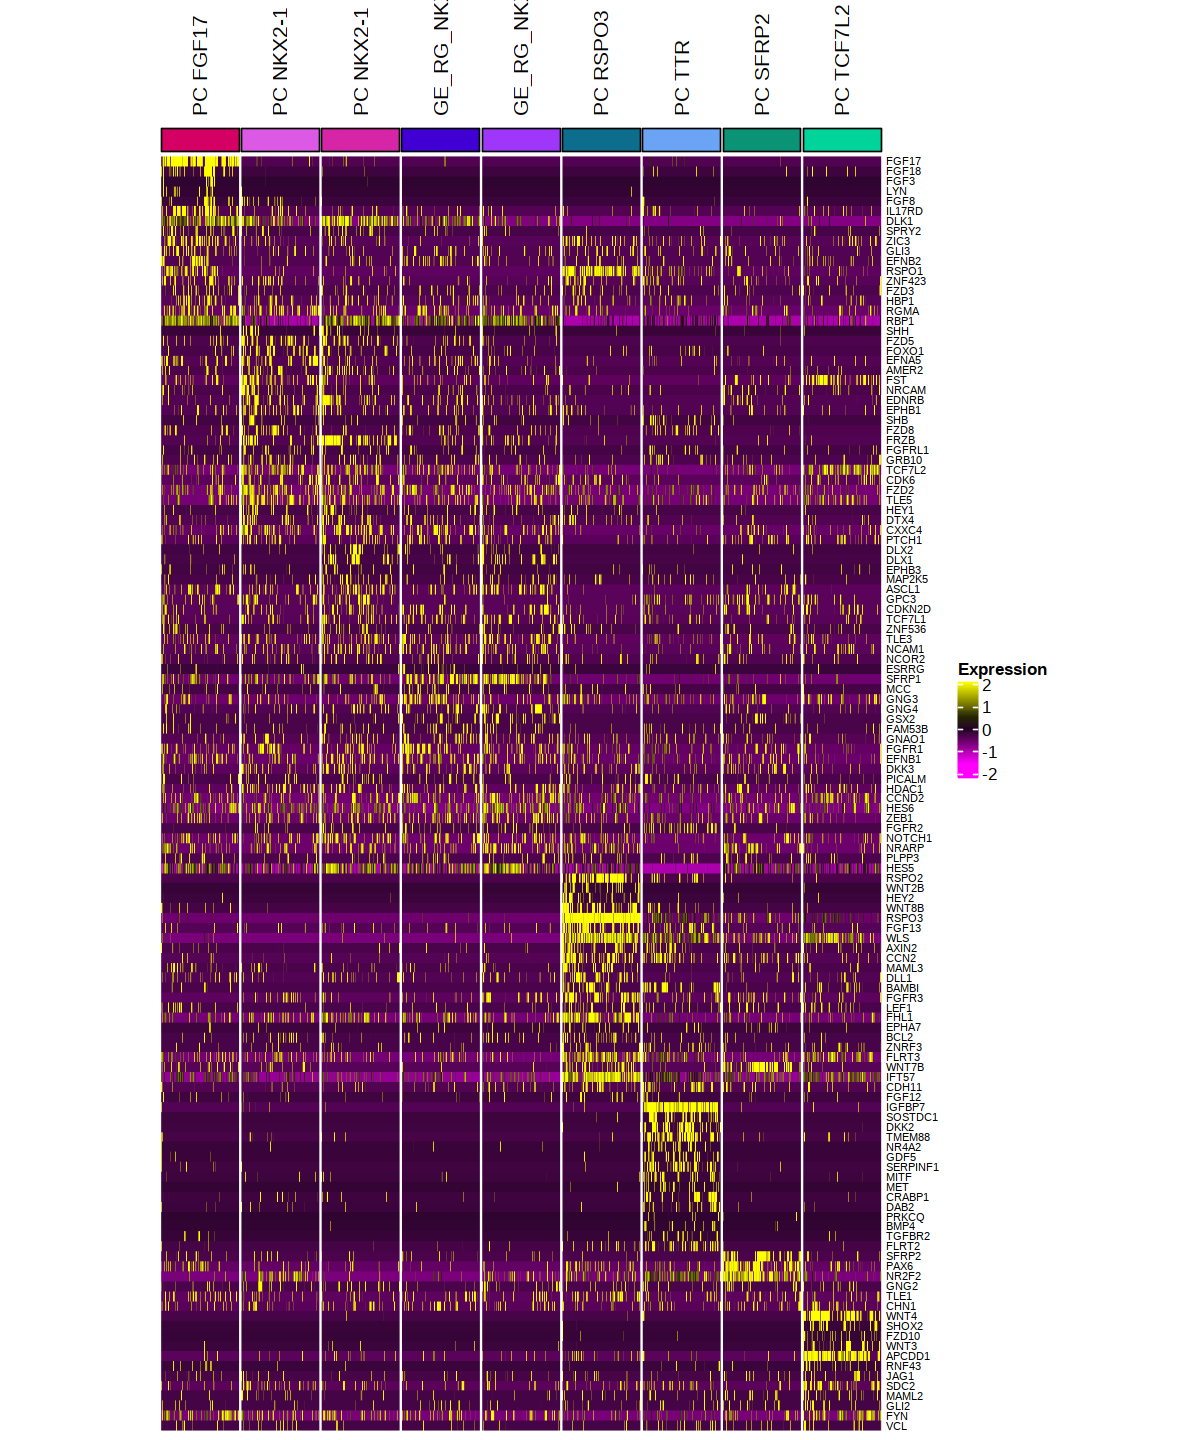

In [12]:
fun1 <- colorRampPalette(c("#FF00FF", "black", "#FFFF00"))
col_fun = circlize::colorRamp2(c(-1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2), fun1(8))
cls_cols <- c("#d40063", "#dc59e5", "#d626a7", "#4000d4", "#9f37fa", "#0c6e8c", "#6ba4f4", "#0b9376", "#00d49b") %>% 
               setNames(., c("PC FGF17", "PC NKX2-1 NKX6-2", "PC NKX2-1 LMO1", 
                             "GE_RG_NKX2-1_DLK1", "GE_RG_NKX2-1_OLIG1", 
                             "PC RSPO3", "PC TTR", "PC SFRP2", "PC TCF7L2"))
htlist <- Heatmap(mat, name = "Expression",  
        column_split = pat_plot@meta.data$cluster,
        cluster_columns = TRUE,
        show_column_dend = FALSE,
        cluster_column_slices = FALSE,
        cluster_row_slices = FALSE,
        column_title_gp = gpar(fontsize = 12),
        row_title_gp = gpar(fontsize = 0),
        column_gap = unit(0.5, "mm"),
        cluster_rows = FALSE,
        show_row_dend = FALSE,
        col = col_fun,
        row_names_gp = gpar(fontsize = 6),
        column_title_rot = 90,
        top_annotation = HeatmapAnnotation(foo = anno_block(gp = gpar(fill = cls_cols))),
        show_column_names = FALSE,
        show_row_names = TRUE,
        use_raster = TRUE,
        raster_quality = 4, 
        width = unit(6, "in"))
options(repr.plot.width=10, repr.plot.height=12)
draw(htlist)

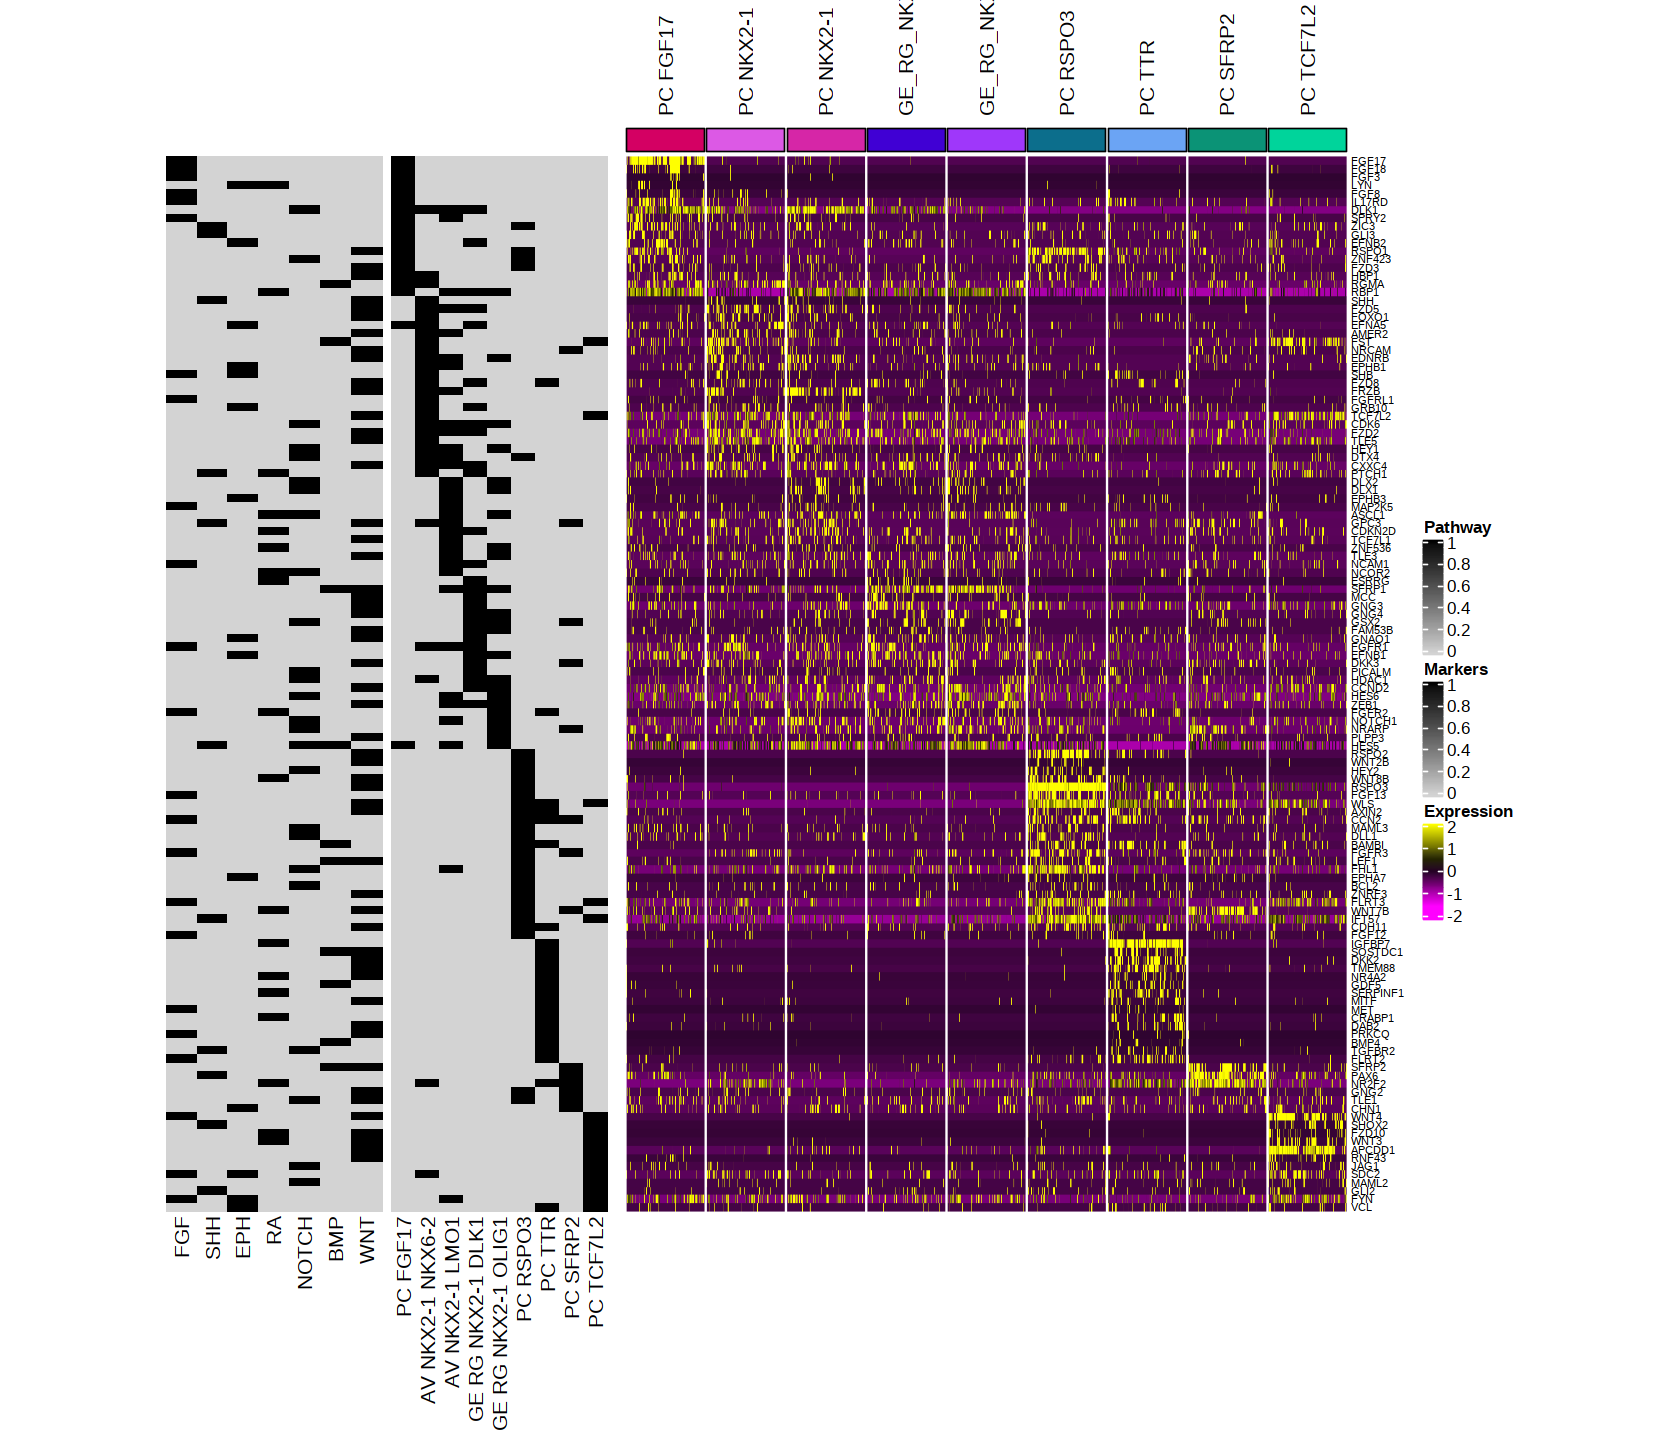

In [13]:
left_heat1 <- Heatmap(annot_mar, name = "Markers", 
                cluster_columns = FALSE,
                show_column_dend = FALSE,
                cluster_column_slices = FALSE,
                cluster_row_slices = FALSE,
                column_title_gp = gpar(fontsize = 12),
                row_title_gp = gpar(fontsize = 0),
                column_gap = unit(0.5, "mm"),
                cluster_rows = FALSE,
                show_row_dend = FALSE,
                col = colorRamp2(c(0,1), c("lightgrey", "black")),
                row_names_gp = gpar(fontsize = 7),
                column_title_rot = 90,
                show_column_names = TRUE,
                show_row_names = FALSE,
                use_raster = FALSE,
                width = unit(1.8, "in"))
left_heat2 <- Heatmap(annot_pathway, name = "Pathway", 
                cluster_columns = FALSE,
                show_column_dend = FALSE,
                cluster_column_slices = FALSE,
                cluster_row_slices = FALSE,
                column_title_gp = gpar(fontsize = 12),
                row_title_gp = gpar(fontsize = 0),
                column_gap = unit(0.5, "mm"),
                cluster_rows = FALSE,
                show_row_dend = FALSE,
                col = colorRamp2(c(0,1), c("lightgrey", "black")),
                row_names_gp = gpar(fontsize = 7),
                column_title_rot = 90,
                show_column_names = TRUE,
                show_row_names = FALSE,
                use_raster = FALSE,
                width = unit(1.8, "in"))
htlist <- left_heat2 + left_heat1 + htlist
options(repr.plot.width=14, repr.plot.height=12)
draw(htlist)

In [14]:
pdf(paste0(outputdir, "PAT_markers_heatmap_combine_pathway.pdf"), width = 20, height = 16)
draw(htlist)
dev.off()

png 
  2

In [15]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.9 (Maipo)

Matrix products: default
BLAS:   /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRblas.so
LAPACK: /gpfs/ycga/home/sm2726/packages/R_versions/R-3.6.1/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] ggplot2_3.3.0        circlize_0.4.13      dplyr_1.0.7         
[4] ComplexHeatmap_2.2.0 Seurat_3.1.5        

loaded via a namespace (and not attached):
  [1] nlme